# Customer churn analysis

## Exploratory data analysis (EDA)

This demo is continuation of the telco pipeline after data load, clean and transformation. We will now try to explore data using snowpark and other python library. This task help us identify further transformations, importatn variable discovery and any feature engineering thats required later.

## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings




In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *

import pandas as pd

from sklearn import linear_model

import matplotlib.pyplot as plt

%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

#Snowflake connection info
from config import snowflake_conn_prop


# lets import some tranformations functions
from snowflake.snowpark.functions import udf, col, lit, translate, is_null, iff

In [2]:
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowflake_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 5, 0, None)
[Row(CURRENT_WAREHOUSE()='COMPUTE_WH', CURRENT_DATABASE()='DEV', CURRENT_SCHEMA()='LANDING')]


In [3]:
%%time

raw = session.table('TRAIN_DATASET').sample(n = 20000)
data = raw.toPandas()

CPU times: user 1.05 s, sys: 70.1 ms, total: 1.12 s
Wall time: 1.94 s


In [4]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
data.head()

CUSTOMERID  COUNT  GENDER  SENIORCITIZEN  PARTNER  DEPENDENTS  \
0  2623-grQIf      1    Male          False    False       False   
1  6586-7mg8J      1    Male          False     True       False   
2  6022-n3bKp      1    Male          False     True        True   
3  7974-ouvLe      1  Female          False     True       False   
4  7549-o9hfK      1    Male          False     True        True   

   TENUREMONTHS PHONESERVICE MULTIPLELINES INTERNETSERVICE ONLINESECURITY  \
0             4          Yes            No     Fiber optic             No   
1            71          Yes           Yes             DSL            Yes   
2            55          Yes            No     Fiber optic             No   
3            37          Yes           Yes     Fiber optic             No   
4            55          Yes           Yes     Fiber optic             No   

  ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES  \
0           No               No          No          No              No   
1           No              Yes         Yes         Yes             Yes   
2          Yes               No         Yes          No              No   
3           No              Yes          No          No              No   
4           No               No          No          No             Yes   

         CONTRACT PAPERLESSBILLING              PAYMENTMETHOD  MONTHLYCHARGES  \
0  Month-to-month             true           Electronic check           70.20   
1        Two year            false           Electronic check           83.20   
2  Month-to-month            false           Electronic check           79.40   
3  Month-to-month             true    Credit card (automatic)           78.95   
4  Month-to-month            false  Bank transfer (automatic)           85.50   

   TOTALCHARGES  CHURNVALUE  
0        237.95         1.0  
1       6126.10         0.0  
2       4238.45         0.0  
3       2839.65         1.0  
4       4713.40         0.0

In [5]:
print(data.shape)

(20000, 22)


## Check Target Distribution

Let's begin by exploring the target distribution.

In [6]:
# We'll print the target variable, target names, and frequency of each unique value:

(unique, counts) = np.unique(data['CHURNVALUE'], return_counts=True)

print('Unique values of target variable', unique)
print('Counts of target variable', counts)

Unique values of target variable [0. 1.]
Counts of target variable [13536  6464]


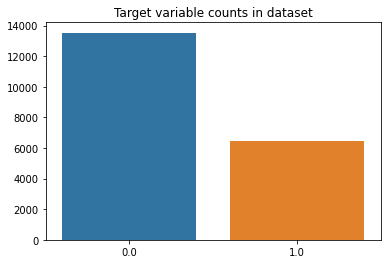

In [7]:
sns.barplot(x=unique, y=counts)
plt.title('Target variable counts in dataset')
plt.show()

## Step 1: Define explonatory variables and target variable

In [8]:
data.head()

CUSTOMERID  COUNT  GENDER  SENIORCITIZEN  PARTNER  DEPENDENTS  \
0  2623-grQIf      1    Male          False    False       False   
1  6586-7mg8J      1    Male          False     True       False   
2  6022-n3bKp      1    Male          False     True        True   
3  7974-ouvLe      1  Female          False     True       False   
4  7549-o9hfK      1    Male          False     True        True   

   TENUREMONTHS PHONESERVICE MULTIPLELINES INTERNETSERVICE ONLINESECURITY  \
0             4          Yes            No     Fiber optic             No   
1            71          Yes           Yes             DSL            Yes   
2            55          Yes            No     Fiber optic             No   
3            37          Yes           Yes     Fiber optic             No   
4            55          Yes           Yes     Fiber optic             No   

  ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES  \
0           No               No          No          No              No   
1           No              Yes         Yes         Yes             Yes   
2          Yes               No         Yes          No              No   
3           No              Yes          No          No              No   
4           No               No          No          No             Yes   

         CONTRACT PAPERLESSBILLING              PAYMENTMETHOD  MONTHLYCHARGES  \
0  Month-to-month             true           Electronic check           70.20   
1        Two year            false           Electronic check           83.20   
2  Month-to-month            false           Electronic check           79.40   
3  Month-to-month             true    Credit card (automatic)           78.95   
4  Month-to-month            false  Bank transfer (automatic)           85.50   

   TOTALCHARGES  CHURNVALUE  
0        237.95         1.0  
1       6126.10         0.0  
2       4238.45         0.0  
3       2839.65         1.0  
4       4713.40         0.0

In [9]:
# let's identify the categorical variables
# we will capture those of type *object* and boolean
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]

# Remove misinterpreted objects like "CustomerID"
cat_vars.pop(0)

print(cat_vars)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']


In [10]:
# now let's identify the numerical variables
num_vars = [var for var in data.columns if var not in cat_vars and var != 'CHURNVALUE' and 'CUSTOMERID' not in var]

# number of numerical variables
print(num_vars)

['COUNT', 'TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


   COUNT  TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES
0      1             4           70.20        237.95
1      1            71           83.20       6126.10
2      1            55           79.40       4238.45
3      1            37           78.95       2839.65
4      1            55           85.50       4713.40


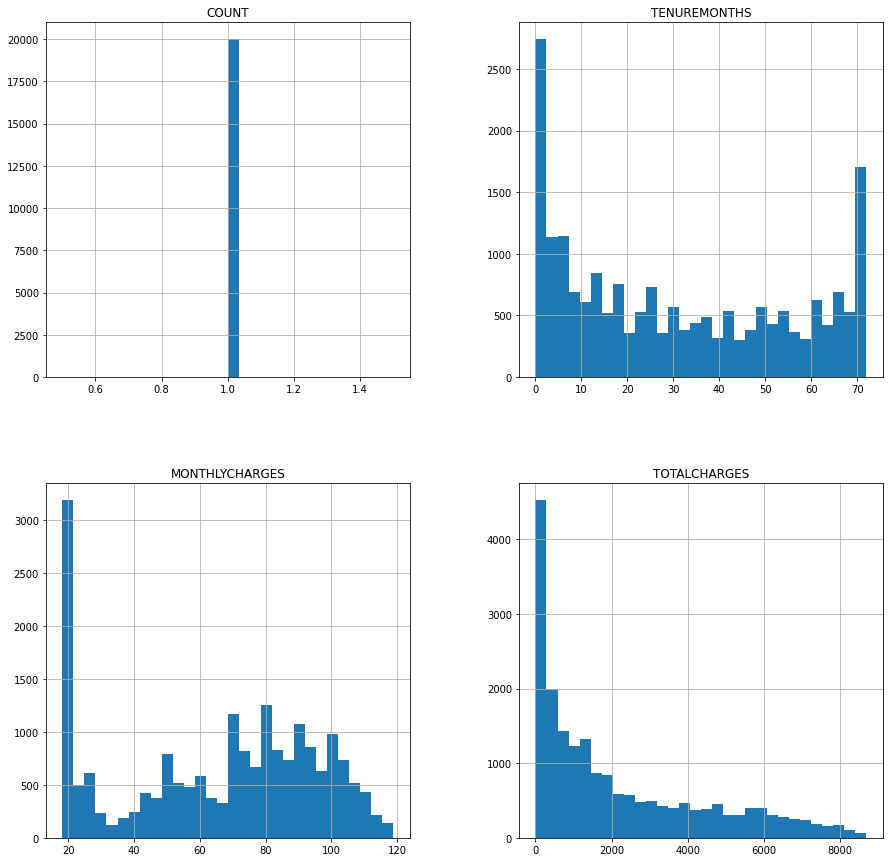

In [11]:
# lets plot histograms for all continuous variables
print(data[num_vars].head())
data[num_vars].hist(bins=30, figsize=(15,15))
plt.show()

# Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [12]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

# Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset

In [16]:
print('Number of numerical variables: ', len(num_vars))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_df = data[num_vars]
scaler.fit(num_df,y=None)

# visualise the numerical variables
num_df.head()
# Before Transformation

Number of numerical variables:  4


COUNT  TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES
0      1             8           51.30        411.60
1      1            30           69.10       2093.90
2      1            16           88.45       1422.10
3      1            40          106.00       4178.65
4      1            13           79.25       1111.65

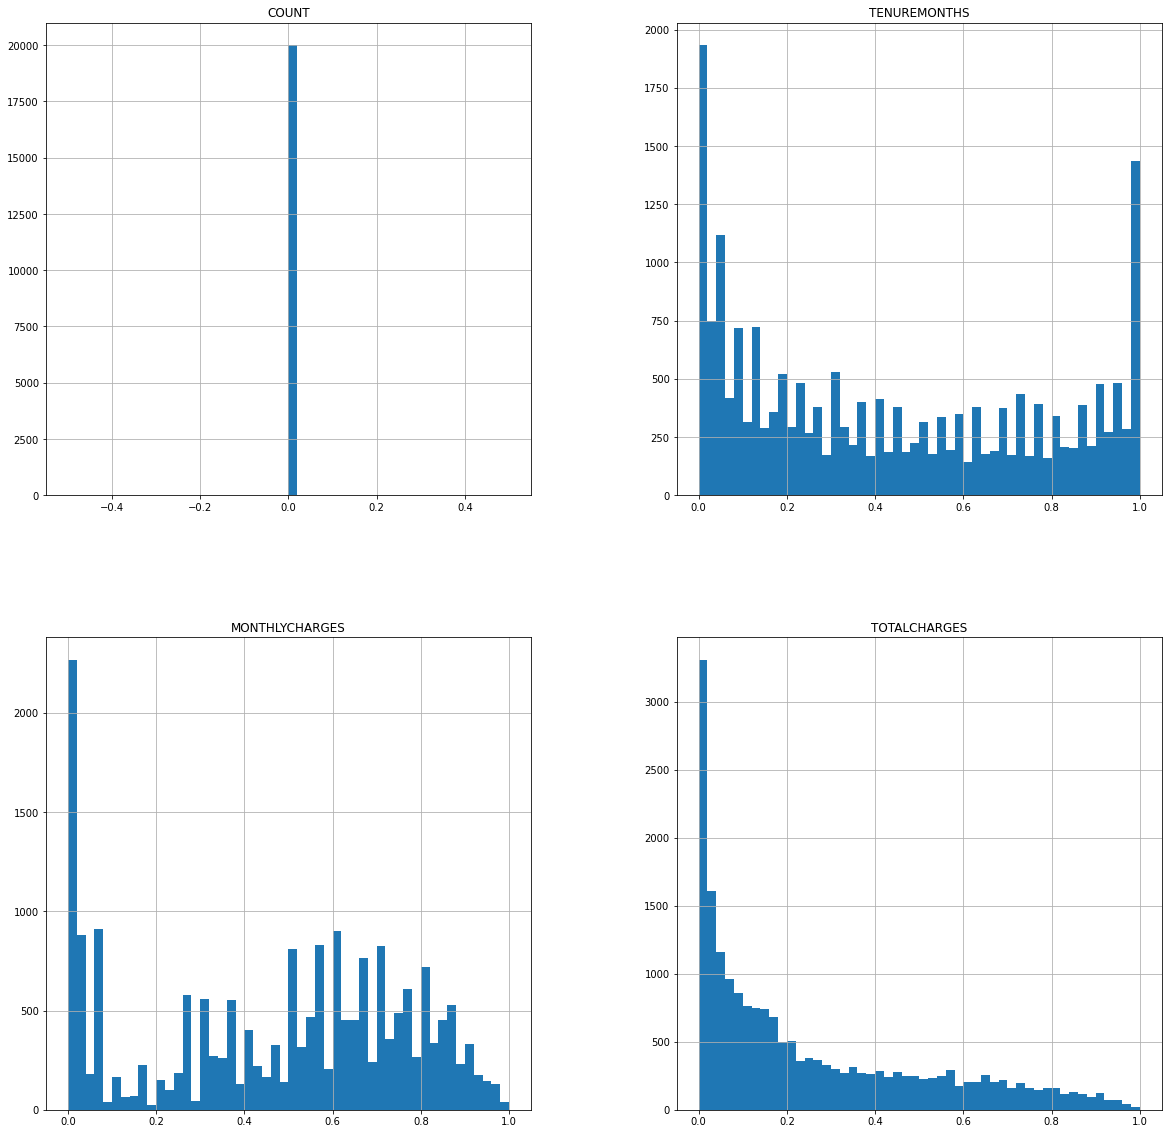

In [17]:
# lets plot histograms for all continuous variables after they are scaled
new_df = pd.DataFrame(scaler.transform(num_df),columns=data[num_vars].columns)

#new_df2 = pd.DataFrame(np.log(new_df),columns=data[num_vars].columns)
new_df.head()
new_df.hist(bins=50, figsize=(20,20))
plt.show()

## Taking care of outliers

In [18]:
def drop_outliers(df,out_name):
    iqr = 1.5 * (np.percentile(df[out_name], 75) - np.percentile(df[out_name], 25))
    df.drop(df[df[out_name] > (iqr + np.percentile(df[out_name], 75))].index, inplace=True)
    df.drop(df[df[out_name] < (np.percentile(df[out_name], 25) - iqr)].index, inplace=True)
    

drop_outliers(data,'TENUREMONTHS')
drop_outliers(data,'MONTHLYCHARGES')
drop_outliers(data,'TOTALCHARGES')


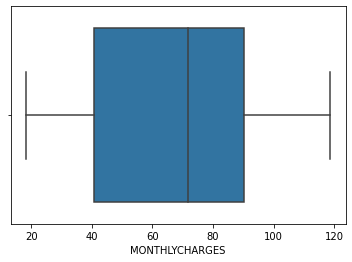

In [19]:
sns.boxplot(x=data['MONTHLYCHARGES'])
plt.show()

# Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [20]:
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  16


In [21]:
# let's preview the categorical variables
data[cat_vars].head()

GENDER  SENIORCITIZEN  PARTNER  DEPENDENTS PHONESERVICE MULTIPLELINES  \
0    Male          False     True        True          Yes            No   
1    Male           True    False       False          Yes           Yes   
2  Female          False    False       False          Yes           Yes   
3    Male          False     True       False          Yes           Yes   
4  Female          False    False        True          Yes            No   

  INTERNETSERVICE ONLINESECURITY ONLINEBACKUP DEVICEPROTECTION TECHSUPPORT  \
0             DSL            Yes           No               No          No   
1             DSL             No           No              Yes         Yes   
2     Fiber optic             No           No              Yes          No   
3     Fiber optic             No          Yes              Yes          No   
4     Fiber optic             No          Yes              Yes          No   

  STREAMINGTV STREAMINGMOVIES        CONTRACT PAPERLESSBILLING  \
0          No              No  Month-to-month             true   
1         Yes              No        Two year             true   
2          No             Yes  Month-to-month             true   
3         Yes             Yes        One year             true   
4          No              No  Month-to-month             true   

               PAYMENTMETHOD  
0    Credit card (automatic)  
1    Credit card (automatic)  
2           Electronic check  
3  Bank transfer (automatic)  
4           Electronic check

## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the variables.

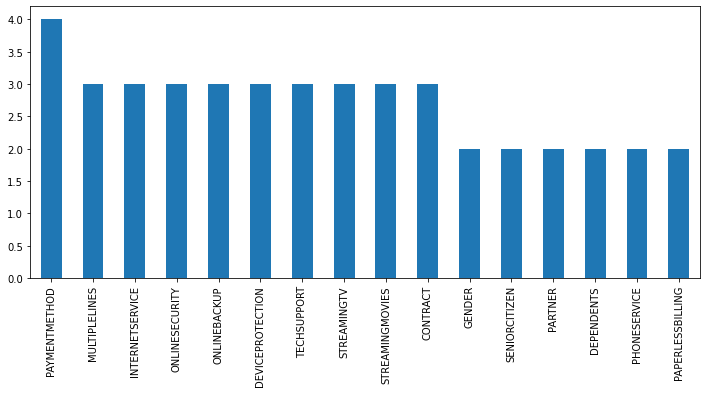

In [22]:
# get the number of unique values (cardinality) for each categorical variable

data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5));

## Rare labels:

Let's go ahead and investigate now if there are labels that are present only in a small number of customers:

In [23]:
print(cat_vars)
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['CHURNVALUE'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']
Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)



### So all the cat variables are distributed well

In [24]:
data[cat_vars].shape, data[num_vars].shape, data['CHURNVALUE'].shape

((19990, 16), (19990, 4), (19990,))

In [25]:
# final columns that we want in our training data set are cat, num and target variables
final_cols = cat_vars + num_vars + ['CHURNVALUE']
final_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'COUNT',
 'TENUREMONTHS',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'CHURNVALUE']

In [26]:
%%time
snowpark_train_df = session.write_pandas(data[final_cols], 'TELCO_TRAIN_SET', auto_create_table=True)

CPU times: user 289 ms, sys: 29.9 ms, total: 319 ms
Wall time: 3.85 s


In [27]:
snowpark_train_df.toPandas()

GENDER  SENIORCITIZEN  PARTNER  DEPENDENTS PHONESERVICE  \
0        Male          False     True        True          Yes   
1        Male           True    False       False          Yes   
2      Female          False    False       False          Yes   
3        Male          False     True       False          Yes   
4      Female          False    False        True          Yes   
...       ...            ...      ...         ...          ...   
19985    Male           True     True        True          Yes   
19986    Male          False     True       False           No   
19987  Female          False     True        True          Yes   
19988    Male          False    False       False          Yes   
19989  Female          False    False        True           No   

          MULTIPLELINES INTERNETSERVICE ONLINESECURITY ONLINEBACKUP  \
0                    No             DSL            Yes           No   
1                   Yes             DSL             No           No   
2                   Yes     Fiber optic             No           No   
3                   Yes     Fiber optic             No          Yes   
4                    No     Fiber optic             No          Yes   
...                 ...             ...            ...          ...   
19985               Yes             DSL            Yes          Yes   
19986  No phone service             DSL             No           No   
19987               Yes             DSL             No           No   
19988               Yes     Fiber optic             No          Yes   
19989  No phone service             DSL             No           No   

      DEVICEPROTECTION TECHSUPPORT STREAMINGTV STREAMINGMOVIES  \
0                   No          No          No              No   
1                  Yes         Yes         Yes              No   
2                  Yes          No          No             Yes   
3                  Yes          No         Yes             Yes   
4                  Yes          No          No              No   
...                ...         ...         ...             ...   
19985              Yes          No          No             Yes   
19986              Yes          No         Yes             Yes   
19987               No          No          No              No   
19988               No          No          No             Yes   
19989               No          No          No              No   

             CONTRACT PAPERLESSBILLING              PAYMENTMETHOD  COUNT  \
0      Month-to-month             true    Credit card (automatic)      1   
1            Two year             true    Credit card (automatic)      1   
2      Month-to-month             true           Electronic check      1   
3            One year             true  Bank transfer (automatic)      1   
4      Month-to-month             true           Electronic check      1   
...               ...              ...                        ...    ...   
19985        Two year             true  Bank transfer (automatic)      1   
19986  Month-to-month             true           Electronic check      1   
19987  Month-to-month            false               Mailed check      1   
19988  Month-to-month             true           Electronic check      1   
19989  Month-to-month            false               Mailed check      1   

       TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES  CHURNVALUE  
0                 8           51.30        411.60         0.0  
1                30           69.10       2093.90         0.0  
2                16           88.45       1422.10         1.0  
3                40          106.00       4178.65         0.0  
4                13           79.25       1111.65         1.0  
...             ...             ...           ...         ...  
19985            50           75.15       3822.45         0.0  
19986             1           50.35         50.35         1.0  
19987            28           49.90       1410.25         0.0  
19988          

# Off to training a model and deplyment


In [28]:
session.close()